# Install package

In [ ]:
!pip install mitiq
!pip install qiskit


In [ ]:
pip install pylatexenc

# Direction of file path

In [ ]:
# run it if you use colab and want to data into your google drive. Or, just ignore it.
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
path_dir='' # where you want to save

# Import Package

In [ ]:

import numpy as np
from qiskit import *
import qiskit
from qiskit import Aer
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel
import qiskit.providers.aer.noise as noise
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error
import pandas as pd
from qiskit.test.mock import *
import matplotlib.pyplot as plt
from qiskit.providers.aer import AerSimulator
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
import itertools
import mitiq
import argparse
# import cma
import os
import sys
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
import atexit
import random

In [ ]:
from qiskit import *
# Qiskit module
from qiskit import QuantumCircuit
import qiskit.circuit.library as circuit_library
import qiskit.quantum_info as qi
import qiskit.ignis.mitigation as mit

# Qiskit tools for running and monitoring jobs
from qiskit import execute
from qiskit.tools.monitor import job_monitor

from qiskit.tools.visualization import *
import matplotlib.pyplot as plt
import math
import numpy as np

import scipy
from scipy.special import erf
from scipy.sparse import csc_matrix
# Other imports
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# Qiskit for pulse 
from qiskit import pulse

from qiskit import *
from qiskit.pulse import Play, Schedule, DriveChannel, ControlChannel, Waveform, ShiftPhase
from qiskit.pulse.library import drag, GaussianSquare, Drag
from qiskit.visualization import SchedStyle
from qiskit.providers.aer import AerSimulator

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

from qiskit.circuit.gate import Gate
from mitiq import zne 

from qiskit.ignis.mitigation.measurement import (
    tensored_meas_cal,
    TensoredMeasFitter,
    TensoredFilter)

import time
from IPython.display import display, clear_output

In [ ]:
mitiq.about()


Mitiq: A Python toolkit for implementing error mitigation on quantum computers
Authored by: Mitiq team, 2020 & later (https://github.com/unitaryfund/mitiq)

Mitiq Version:	0.10.0

Core Dependencies
-----------------
Cirq Version:	0.10.0
NumPy Version:	1.20.3
SciPy Version:	1.7.1

Optional Dependencies
---------------------
PyQuil Version:	Not installed
Qiskit Version:	0.31.0
Braket Version:	Not installed

Python Version:	3.7.12
Platform Info:	Linux (x86_64)


# RZZ gate pulse schedule

In [ ]:
def cx_pulse_instructions(qc: int, qt: int):
    """Retrieve the CNOT pulse schedule for the given
    qubit pair from the backend defaults.
    
    Args:
      qc: control qubit index
      qt: target qubit index
    """
    if [qc, qt] not in backend_config.coupling_map:
        print('Qubit pair has no direct cross resonance!')
    else:
        cx = inst_sched_map.get('cx', qubits=[qc, qt])
        return cx

def Extract_GaussianSquare(q1, q2):
    """Retrieve the Gaussiacross resonance pulse waveform
    for the qubit pair from the cx (CNOT) schedule.
    
    Args:
      q1: control qubit index
      q2: target qubit index
    """
    cx = cx_pulse_instructions(q1, q2)
    cx1 = cx_pulse_instructions(q2, q1)
       
    if cx.instructions[-1][0] < cx1.instructions[-1][0]: # get longer cnot gate pulse schedule 
        cx=cx1
    idx = 0
    Dr_gs = [] # get the gaussiansquare pulse of drive channel
    cr_gs = [] # get the gaussiansquare pulse of control channel
    control_channel='' # get the corresponding control channel for q1 and q2
    Drive_Channel=''    # get the corresponding drive channel with gaussiansquare pulse
    another_Drive_Channel='' # get another drive channel
    
    #look for them
    
    N = 1
    for i in range(len(cx.instructions)):
        if type(cx.instructions[i][1]) is ShiftPhase and type(cx.instructions[i][1].channel) is DriveChannel\
        and cx.instructions[i][1].phase == -math.pi/2 and N == 1 :
            
            another_Drive_Channel=cx.instructions[i][1].channels[0]
            
        if type(cx.instructions[i][1].channels[0]) is ControlChannel and type(cx.instructions[i][1]) is Play\
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            cr_gs.append(cx.instructions[i][1].pulse)

            control_channel=cx.instructions[i][1].channels[0]

        if type(cx.instructions[i][1].channels[0]) is DriveChannel and type(cx.instructions[i][1]) is Play \
          and type(cx.instructions[i][1].pulse) is GaussianSquare:

            Dr_gs.append(cx.instructions[i][1].pulse)

            Drive_Channel=cx.instructions[i][1].channels[0]
        if type(cx.instructions[i][1]) is Play:
            N=0

    return control_channel, cr_gs, Drive_Channel, Dr_gs, another_Drive_Channel


def Get_Shift_phase_CRTL_Chan(q1, q2): # When driving channel is phase shifted, the corresponding control channel need to be phase shifted. 
    """Get the driving channels' corresponding control channels
    
    Args:
      q1: qubit
      q2: qubit
    out_put: 
      control_chan1: the corresponding control channel of driving channel with 
    """
    cx1 = cx_pulse_instructions(q1, q2)
    cx2 = cx_pulse_instructions(q2, q1)
    if cx1.instructions[-1][0] > cx2.instructions[-1][0]:
        cx1, cx2 = cx2, cx1
    control_chan0 = []
    control_chan1 = []
    for i in range(len(cx2.instructions)):
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi/2 :
            control_chan0.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is ShiftPhase and type(cx2.instructions[i][1].channel) is ControlChannel\
        and cx2.instructions[i][1].phase == -math.pi :
            control_chan1.append(cx2.instructions[i][1].channel)
        if type(cx2.instructions[i][1]) is Play:
            break

    return control_chan0, control_chan1 

def Rzz_gate_schedule (q0,q1,theta):
    """
    Referenced the paper John P. T. Stenger, Nicholas T. Bronn, Daniel J. Egger, and David Pekker
    Phys. Rev. Research 3, 033171 
    
    Args:
      q1: qubit
      q2: qubit
      theta: rotating angle
      backend: quantum hardware Device
      
    out_put:
        
      Return Rzz Pulse
    """
    
    uchan, cr_pulse, Dchan, dr_pulse, another_Dchan = Extract_GaussianSquare(q0, q1)
    #Y_chan, X_chan = Get_XY_chan(q0,q1)
    control_chan0, control_chan1 = Get_Shift_phase_CRTL_Chan(q0, q1)
    
    Frac = 2*np.abs(theta)/math.pi
    
    Y_q = Dchan.index
    
    X_q = another_Dchan.index
    
    Y90p = inst_sched_map.get('u2', P0=0, P1=0, qubits=[Y_q]).instructions
    
    X_180 = inst_sched_map.get('x', qubits=[X_q]).instructions[0][1].pulse
    
    ### find out Y_90 pulse 
    
    for Y in Y90p:
        
        if type(Y[1]) is Play:
            
            Y_pulse = Y[1].pulse
            
    ###
            
    drive_samples = Y_pulse.duration # The duration of Y pulse
    
    cr_samples = cr_pulse[0].duration # The duration gaussiansquare pulse
    
    cr_width= cr_pulse[0].width # gaussiansquare pulse's width
    
    cr_sigma = cr_pulse[0].sigma # gaussiansquare pulse's standard error
    
    cr_amp = np.abs(cr_pulse[0].amp)
    
    number_std = (cr_samples-cr_width)/cr_sigma
    
    Area_g = cr_amp*cr_sigma*np.sqrt(2*np.pi)*erf(number_std) 
    
    Area_pi_2 = cr_width*cr_amp+Area_g 
    
    dr_sigma = dr_pulse[0].sigma
    
    Area_theta = Frac * Area_pi_2
    
    if Area_theta > Area_g:
        
        New_width = (Area_theta-Area_g)/cr_amp
        
        new_duration = math.ceil((New_width+number_std*cr_sigma)/16)*16
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_pulse[0].amp, sigma=cr_sigma, width=New_width)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_pulse[0].amp, sigma=dr_sigma, width=New_width)
        
        
    else:
        
        New_amp_cr =  cr_pulse[0].amp*Area_theta/Area_g
        
        New_amp_dr= dr_pulse[0].amp*Area_theta/Area_g
        
        new_duration = number_std * cr_sigma
        
        cr_pulse[0] = GaussianSquare(duration=new_duration, amp=cr_amp, sigma=cr_sigma, width=0)
        
        cr_pulse[1] = GaussianSquare(duration=new_duration, amp=-cr_amp, sigma=cr_sigma, width=0)
        
        dr_pulse[0] = GaussianSquare(duration=new_duration, amp=dr_amp, sigma=dr_sigma, width=0)
        
        dr_pulse[1] = GaussianSquare(duration=new_duration, amp=-dr_amp, sigma=dr_sigma, width=0)
        
    # Set up the Rzz schedule
    if theta < 0 :
  
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_-90 pulse
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) 
    
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) 
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(drive_samples)
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_90 pulse

        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
    
        return RZZ_schedule
    
    else:
        
        RZZ_schedule = pulse.Schedule(name="RZZ gate pulse") 
    
        ### Y_90 pulse
    
    
        RZZ_schedule |= Play(Y_pulse, Dchan)
    
        
         ### 
    
         ### Cross resonant pulses and X rotation echo pulse
    
        RZZ_schedule |= Play(dr_pulse[0], Dchan) << int(drive_samples)
        RZZ_schedule |= Play(cr_pulse[0], uchan) << int(drive_samples)
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(new_duration+drive_samples)

        RZZ_schedule |= Play(dr_pulse[1], Dchan) << int(new_duration+2*drive_samples)
        RZZ_schedule |= Play(cr_pulse[1], uchan) << int(new_duration+2*drive_samples)
    
         ###
    
         ### X_180 pulse
    
        RZZ_schedule |= Play(X_180, another_Dchan) << int(2*new_duration+2*drive_samples)
    
         ## Y_-90 pulse
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+2*drive_samples)
        
        for chan in control_chan1:
            
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= Play(Y_pulse, Dchan) << int(2*new_duration+2*drive_samples)
        
        RZZ_schedule |= ShiftPhase(-math.pi, Dchan) << int(2*new_duration+3*drive_samples)
    
        for chan in control_chan1: 
        
            RZZ_schedule |= ShiftPhase(-math.pi, chan) << int(2*new_duration+3*drive_samples)
    
        return RZZ_schedule

# Load token and get the provider

In [ ]:
IBMQ.save_account('',overwrite=True )
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [ ]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_statevector = provider.get_backend('simulator_statevector')

#Your provider
provider = IBMQ.get_provider()

In [ ]:
backend = provider.get_backend('')

properties = backend.properties()

In [ ]:
backend_config = backend.configuration()
ham_params = backend_config.hamiltonian['vars']
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns")

Sampling time: 0.2222222222222222 ns


In [ ]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map 
inst_sched_map.instructions

['cx', 'id', 'measure', 'rz', 'sx', 'u1', 'u2', 'u3', 'x']

# Random benckmark for Rzz

In [ ]:
from qiskit.ignis.verification import randomized_benchmarking as rb
from qiskit.ignis.verification import InterleavedRBFitter

In [ ]:
qubits_list=[1,2,3,5,8,11,14,13,12,10,7,4]
q_conn = []
for i in range(len(qubits_list)-1):
  q_conn.append([qubits_list[i],qubits_list[i+1]])

In [ ]:
# generate the RB circuit parameters
Tw_cnot_err=[]
for selected_pair in q_conn:
  length_vector = np.arange(1,200,20)
  nseeds = 5

  rb_pattern = [selected_pair]

  qc = QuantumCircuit(2)
  qc.id(0) 
  interleaved_elem = [qc]

  rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(length_vector=length_vector,
                                              nseeds=nseeds,
                                              rb_pattern=rb_pattern,
                                              interleaved_elem=interleaved_elem)
  qc_seeds=[]
  for h in range(len(circuits_interleaved)):
      qc_tests=[]
      for j in range(len(circuits_interleaved[h])):
          qc_test = QuantumCircuit(*circuits_interleaved[h][j].qregs,*circuits_interleaved[h][j].cregs)
          qc_test.name=circuits_interleaved[h][j].name
          for i in circuits_interleaved[h][j][:]:
              if type(i[0]) is qiskit.circuit.library.standard_gates.i.IGate:
                  qc_test.rzz(-2.0,selected_pair[0],selected_pair[1])
                  qc_test.barrier()
                  qc_test.rzz(2.0,selected_pair[0],selected_pair[1])
              else:
                  qc_test.data.append(i)
          qc_test.add_calibration('rzz', selected_pair, Rzz_gate_schedule(selected_pair[0],selected_pair[1],-2.0), [-2.0])
          qc_test.add_calibration('rzz', selected_pair, Rzz_gate_schedule(selected_pair[0],selected_pair[1],2.0), [2.0])
          qc_tests.append(qc_test)
      qc_seeds.append(qc_tests)
  
  # Execute the non-interleaved RB circuits as a reference 
  shots=1000
  basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
  job_list = []
  result_list = []
  transpile_list = []
  for rb_seed,rb_circ_seed in enumerate(rb_circs):
      print('Compiling seed %d'%rb_seed)
      rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
      print('QC seed %d'%rb_seed)
      job = execute(rb_circ_transpile, shots=shots, backend=backend)
      print(job.job_id())
      job_list.append(job)
      transpile_list.append(rb_circ_transpile)    


  for job in job_list:
      job_monitor(job)
      try:
          if job.error_message() is not None:
              print(job.error_message())
      except:
          pass
      
  result_list = []
  for job in job_list:
      result_list.append(job.result())

  
  rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_pattern)

  for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
      plt.figure(figsize=(6, 6))
      axis = [plt.subplot(1, 1, 1)]
      
      # Add another seed to the data
      rbfit.add_data([data])
      
      for i in range(1):
          pattern_ind = i

          # Plot the essence by calling plot_rb_data
          rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

          # Add title and label
          axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
          
      # Display
      display(plt.gcf())
      
      # Clear display after each seed and close
      clear_output(wait=True)
      time.sleep(1.0)
      plt.close()

  shots=1000
  basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
  interleaved_result_list = []
  interleaved_transpile_list = []
  jobs_list=[]
  for rb_seed,rb_circ_seed in enumerate(qc_seeds):
      print('Compiling seed %d'%rb_seed)
      rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
      print('QC seed %d'%rb_seed)
      job = execute(rb_circ_transpile, shots=shots, backend=backend)
      print(job.job_id())
      jobs_list.append(job)
      interleaved_transpile_list.append(rb_circ_transpile)
      
  for job in jobs_list:
      job_monitor(job)
      try:
          if job.error_message() is not None:
              print(job.error_message())
      except:
          pass
      
  #result_list = []
  for job in jobs_list:    
      interleaved_result_list.append(job.result())
        
  print("Finished QC")

  rbfit = rb.fitters.RBFitter(interleaved_result_list[0], xdata, rb_pattern)

  for seed_num, data in enumerate(interleaved_result_list):#range(1,len(result_list)):  
      plt.figure(figsize=(6, 6))
      axis = [plt.subplot(1, 1, 1)]
      
      # Add another seed to the data
      rbfit.add_data([data])
      
      for i in range(1):
          pattern_ind = i

          # Plot the essence by calling plot_rb_data
          rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

          # Add title and label
          axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
          
      # Display
      display(plt.gcf())
      
      # Clear display after each seed and close
      clear_output(wait=True)
      time.sleep(1.0)
      plt.close()
  rb_fit_interleaved = InterleavedRBFitter(result_list, interleaved_result_list, xdata, rb_pattern)
  plt.figure(figsize=(8, 8))
  axis = [plt.subplot(1, 1, 1)]
  rb_fit_interleaved.plot_rb_data(ax=axis[0],add_label=True, show_plt=False)
  Tw_cnot.append(rb_fit_interleaved._fit_interleaved[0]['epc_est']/2)

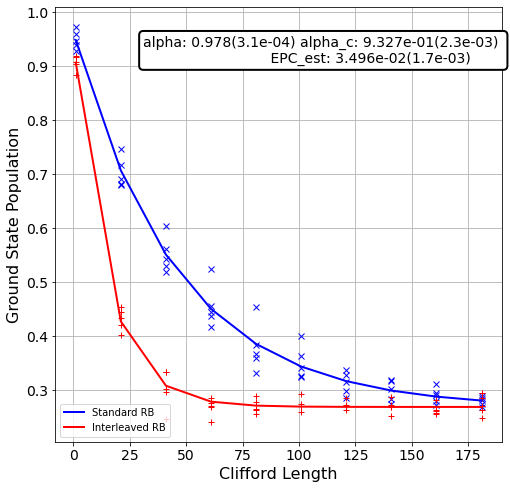

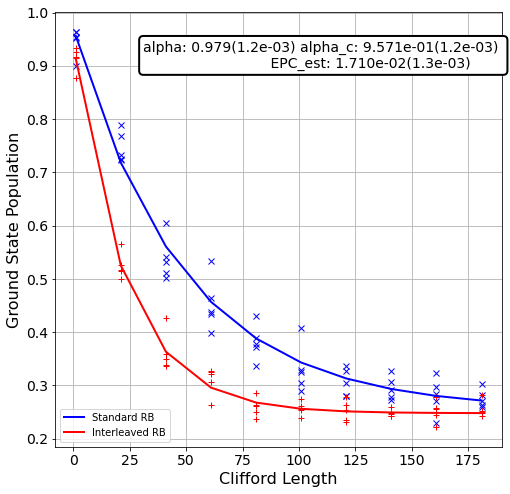

In [ ]:
# generate the RB circuit parameters
Rzz_err=[]
for selected_pair in q_conn:
  length_vector = np.arange(1,200,20)
  nseeds = 5

  rb_pattern = [selected_pair]

  qc = QuantumCircuit(2)
  qc.id(0) 
  interleaved_elem = [qc]

  rb_circs, xdata, circuits_interleaved = rb.randomized_benchmarking_seq(length_vector=length_vector,
                                              nseeds=nseeds,
                                              rb_pattern=rb_pattern,
                                              interleaved_elem=interleaved_elem)
  qc_seeds=[]
  for h in range(len(circuits_interleaved)):
      qc_tests=[]
      for j in range(len(circuits_interleaved[h])):
          qc_test = QuantumCircuit(*circuits_interleaved[h][j].qregs,*circuits_interleaved[h][j].cregs)
          qc_test.name=circuits_interleaved[h][j].name
          for i in circuits_interleaved[h][j][:]:
              if type(i[0]) is qiskit.circuit.library.standard_gates.i.IGate:
                  qc_test.rzz(-2.0,selected_pair[0],selected_pair[1])
                  qc_test.barrier()
                  qc_test.rzz(2.0,selected_pair[0],selected_pair[1])
              else:
                  qc_test.data.append(i)
          qc_test.add_calibration('rzz', selected_pair, Rzz_gate_schedule(selected_pair[0],selected_pair[1],-2.0), [-2.0])
          qc_test.add_calibration('rzz', selected_pair, Rzz_gate_schedule(selected_pair[0],selected_pair[1],2.0), [2.0])
          qc_tests.append(qc_test)
      qc_seeds.append(qc_tests)
  
  # Execute the non-interleaved RB circuits as a reference 
  shots=1000
  basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
  job_list = []
  result_list = []
  transpile_list = []
  for rb_seed,rb_circ_seed in enumerate(rb_circs):
      print('Compiling seed %d'%rb_seed)
      rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
      print('QC seed %d'%rb_seed)
      job = execute(rb_circ_transpile, shots=shots, backend=backend)
      print(job.job_id())
      job_list.append(job)
      transpile_list.append(rb_circ_transpile)    


  for job in job_list:
      job_monitor(job)
      try:
          if job.error_message() is not None:
              print(job.error_message())
      except:
          pass
      
  result_list = []
  for job in job_list:
      result_list.append(job.result())

  
  rbfit = rb.fitters.RBFitter(result_list[0], xdata, rb_pattern)

  for seed_num, data in enumerate(result_list):#range(1,len(result_list)):  
      plt.figure(figsize=(6, 6))
      axis = [plt.subplot(1, 1, 1)]
      
      # Add another seed to the data
      rbfit.add_data([data])
      
      for i in range(1):
          pattern_ind = i

          # Plot the essence by calling plot_rb_data
          rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

          # Add title and label
          axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
          
      # Display
      display(plt.gcf())
      
      # Clear display after each seed and close
      clear_output(wait=True)
      time.sleep(1.0)
      plt.close()

  shots=1000
  basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
  interleaved_result_list = []
  interleaved_transpile_list = []
  jobs_list=[]
  for rb_seed,rb_circ_seed in enumerate(qc_seeds):
      print('Compiling seed %d'%rb_seed)
      rb_circ_transpile = transpile(rb_circ_seed, basis_gates=basis_gates)
      print('QC seed %d'%rb_seed)
      job = execute(rb_circ_transpile, shots=shots, backend=backend)
      print(job.job_id())
      jobs_list.append(job)
      interleaved_transpile_list.append(rb_circ_transpile)
      
  for job in jobs_list:
      job_monitor(job)
      try:
          if job.error_message() is not None:
              print(job.error_message())
      except:
          pass
      
  #result_list = []
  for job in jobs_list:    
      interleaved_result_list.append(job.result())
        
  print("Finished QC")

  rbfit = rb.fitters.RBFitter(interleaved_result_list[0], xdata, rb_pattern)

  for seed_num, data in enumerate(interleaved_result_list):#range(1,len(result_list)):  
      plt.figure(figsize=(6, 6))
      axis = [plt.subplot(1, 1, 1)]
      
      # Add another seed to the data
      rbfit.add_data([data])
      
      for i in range(1):
          pattern_ind = i

          # Plot the essence by calling plot_rb_data
          rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

          # Add title and label
          axis[i].set_title('2 Qubit RB - after seed %d'%(seed_num), fontsize=18)
          
      # Display
      display(plt.gcf())
      
      # Clear display after each seed and close
      clear_output(wait=True)
      time.sleep(1.0)
      plt.close()
  rb_fit_interleaved = InterleavedRBFitter(result_list, interleaved_result_list, xdata, rb_pattern)
  plt.figure(figsize=(8, 8))
  axis = [plt.subplot(1, 1, 1)]
  rb_fit_interleaved.plot_rb_data(ax=axis[0],add_label=True, show_plt=False)
  Rzz_err.append(rb_fit_interleaved._fit_interleaved[0]['epc_est']/2)
  #Rzz_err = rb_fit_interleaved._fit_interleaved[0]['epc_est']

In [ ]:
from numpy.core.fromnumeric import mean
Ave_cnot_err=[]
for i in backend_config.coupling_map:
  Ave_cnot_err.append(properties.gate_error('cx',i))
Ave_cnot_err=mean(Ave_cnot_err)
#Ave_Rzz_err=Ave_cnot_err*Ratio
Ave_Rzz_err=mean(Rzz_err)

In [ ]:
Single_err=[]
for i in backend_config.meas_map[0]:
  Single_err.append(properties.gate_error('x',[i]))
Single_err=mean(Single_err)

# Post Selcetion

In [ ]:
def post_selection(bit_str):
    """This function takes in a bitstring, and will return False iff 
    there is a 1 next to another 1 in the given bitstring.
    This does NOT consider a bitstring with 1s on either end as next to one another,
    i.e. given a string of the form '10...01', this function should return False"""
    new_str = '0' + bit_str[0:len(bit_str)]
    for i in range(0,len(bit_str)+1):
        if (new_str[i] == '1') & (new_str[i] == new_str[i-1]):
            return False
    return True

def post_selected_expval(counts, qubit):
    """This function takes in the counts from a circuit execution, as well as a qubit index, 
    and outputs <Z> for that qubit after post-selection"""
    copy_counts = counts.copy()
    
    total = []

    for x in counts.keys():
        if not post_selection(x):
            copy_counts.pop(x)

    for x in copy_counts:
        total.append(copy_counts[x])

    total = sum(total)

    one_counts = 0

    for x in copy_counts.keys():
        if x[qubit] == '1':
            one_counts += copy_counts[x]

    if total == 0:

      return -1

    prob = one_counts / total

    expval = 2*prob - 1
    
    return expval

# Rabi coupling, Z field, and ZZ interaction.

In [ ]:
#Define the functions used to build the Trotter circuit.
def h_Z(qc,h,dt,qubits_list,cond):

  if cond == 'per':

    if type(qubits_list) == int:

      num =  qubits_list

      for i in range(num):

        qc.rz(2*h*dt,i)
    #j=0
    else:

      for i in qubits_list:
          #if j==0 or j==4:

          qc.rz(2*h*dt,i)

  if cond == 'op':

    if type(qubits_list) == int:

      num =  qubits_list

      for i in range(num):
        
        if i==0 or i==(num-1):

          qc.rz(h*dt,i)

        else:

          qc.rz(2*h*dt,i)
    #j=0
    else:
      j=0
      for i in qubits_list:
          if j==0 or j==len(qubits_list)-1:

            qc.rz(h*dt,i)

          else:

            qc.rz(2*h*dt,i)

          j+=1
        
def X_Rabi(qc,Omega,dt,qubits_list): # Rabi coupling

    if type(qubits_list) == int:

      num =  qubits_list

      for i in range(num):

        qc.rx(2*Omega*dt,i)

    else:
    
      for i in qubits_list:
          
          qc.rx(2*Omega*dt,i)
        
def ZZ(qc,V,dt,qubits_list,cond): # nearest neighbor coupling

    if type(qubits_list) == int:

      num =  qubits_list

      for i in range(1,num-1,2):

        qc.rzz(-2*V*dt,i,i+1)

      if cond == 'per':

        qc.rzz(-2*V*dt,0,num-1)

      for i in range(0,num-1,2):

        qc.rzz(-2*V*dt,i,i+1)

    else:

      for i, j in enumerate(qubits_list[1:-1:2]):
      
        qc.rzz(-2*V*dt,j,qubits_list[2*i+2])

      if cond == 'per':

        qc.rzz(-2*V*dt,qubits_list[0],qubits_list[-1])
      
      for i, j in enumerate(qubits_list[:-1:2]):

        qc.rzz(-2*V*dt,j,qubits_list[2*i+1])
    

# Pulse Gate

In [ ]:
def Trotter_circuit_5_site_Rzz(h,Omega,V,T,n,qubits_list,cond):
    
    #t1,t2=DD_T(h,Omega,V,T,n,qubits_list,cond)
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(backend_config.n_qubits,len(qubits_list))

        for j in qubits_list[1::2]:
        
            Trotter_circuit.x(j)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,qubits_list,cond) # Z field 

            ZZ(Trotter_circuit,V,dt,qubits_list,cond) 

            # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        j=0
        
        for a in qubits_list:
            
            Trotter_circuit.measure(a,j)
            
            j+=1

        for a, b in enumerate(qubits_list[1:-1:2]):

          Trotter_circuit.add_calibration('rzz', [b,qubits_list[2*a+2]], Rzz_gate_schedule(b,qubits_list[2*a+2],-2*V*dt), [-2*V*dt])

        if cond == 'per': 
        
          Trotter_circuit.add_calibration('rzz', [qubits_list[0],qubits_list[-1]], Rzz_gate_schedule(qubits_list[0],qubits_list[-1],-2*V*dt), [-2*V*dt]) 

        for a, b in enumerate(qubits_list[:-1:2]):

          Trotter_circuit.add_calibration('rzz', [b,qubits_list[2*a+1]], Rzz_gate_schedule(b,qubits_list[2*a+1],-2*V*dt), [-2*V*dt])

        Trotter_circuit = transpile(Trotter_circuit, backend)
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

# Twirled RZZ Randomized Folding

In [ ]:
def apply_pauli(circ, num, qb):
    if (num == 0):
        circ.i(qb)
    elif (num == 1):
        circ.x(qb)
    elif (num == 2):
        circ.y(qb)
    else:
        circ.z(qb)
    return circ

def Twirled_for_cnot(circ, qb0, qb1):
    """
    Pauli Twirling for Rzz gate. However, in order to get random Rzz gate folding in mitiq,
    we replace Rzz with Cnot gate first.
    
    """
    M=np.ones((4,4))

    M[0,1]=-1
    M[0,2]=-1
    M[1,0]=-1
    M[1,3]=-1
    M[2,0]=-1
    M[2,3]=-1
    M[3,1]=-1
    M[3,2]=-1

    paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
    paulis.remove((0,0))
    paulis_map = [(i,j) for i in range(0,4) for j in range(0,4)]
    paulis_map.remove((0,0))
    num = random.randrange(len(paulis))

    apply_pauli(circ, paulis[num][0], qb0)
    apply_pauli(circ, paulis[num][1], qb1)

    #angle=M[paulis[num][0],paulis[num][1]]*angle

    #circ.rzz(angle, qb0, qb1)
    circ.cx(qb0, qb1)

    apply_pauli(circ, paulis_map[num][0], qb0)
    apply_pauli(circ, paulis_map[num][1], qb1)

In [ ]:
def C_not(qc,V,dt,qubits_list,cond): # nearest neighbor coupling

    """
    Two qubit gate with Rzz's Pauli Twurling.
    
    Used for Trotter_circuit_5_site_c function.
    """

    num = len(qubits_list)

    for i in range(1,num-1,2):

      Twirled_for_cnot(qc,i,i+1)

    if cond == 'per':

      Twirled_for_cnot(qc,0,num-1)

    for i in range(0,num-1,2):

      Twirled_for_cnot(qc,i,i+1)

#Define the functions used to build the Trotter circuit.
def h_Z_c(qc,h,dt,qubits_list,cond): # Z field 

    num = len(qubits_list)

    if cond == 'per':

      for i in range(num):

        qc.rz(2*h*dt,i)

    if cond == 'op':

      for i in range(num):
        
        if i==0 or i==(num-1):

          qc.rz(h*dt,i)

        else:

          qc.rz(2*h*dt,i)
        
        
def X_Rabi_c(qc,Omega,dt,qubits_list): # Rabi coupling

    num = len(qubits_list)
    
    for i in range(num):
        
        qc.rx(2*Omega*dt,i)

In [ ]:
def Trotter_circuit_5_site_c(h,Omega,V,T,n,qubits_list,cond):

    """ 
    In order to get random Rzz gate folding in mitiq, we replace Rzz with Cnot gate first.
    
    Note: (2021 Oct - 2022 Jan ) Mitiq's random gate folding didn't work with Rzz, Rzx, Rxx and so on. 
    Maybe it can work with Rzz, Rzx, Rxx now. 
    
    """
    
    q_len = len(qubits_list)
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(q_len,q_len)
        
        ### Initial state setting
      
        for j in range(1,q_len,2):
        
            Trotter_circuit.x(j)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi_c(Trotter_circuit,Omega,dt,qubits_list) # Rabi coupling from the second term of Hamiltonian
            
            h_Z_c(Trotter_circuit,h,dt,qubits_list,cond) # Z field 
            
            #Trotter_circuit.barrier()
            
            C_not(Trotter_circuit,V,dt,qubits_list,cond) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
            
        for i in range(q_len):

          Trotter_circuit.measure(i,i)
        
        #Trotter_circuit = transpile(Trotter_circuit, backend) # compile into specific backend
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [ ]:
def TrotterExecutor_random_rzz( backend, n, qubits_list, dt, V, cond, n_Times):
    scale_factors = [1.0, 1.5, 2.0]

    folded_circuits = []


    Omega = 0.2*1.2

    h = -2

    V = -1

    T = 40


    
    Rzz_circuits = []

    #n_Times = 15

    for i in range(n_Times):

      circuits = Trotter_circuit_5_site_c(h,Omega,V,T,n,qubits_list, cond)

      Rzz_circuits = Rzz_circuits+circuits


    #circuits = Trotter_circuit_5_site_c(h,Omega,V,T,n,qubits_list)

    scale_factors = [1.0, 1.5, 2.0]

    folded_circuits = []

    fidelity={"single": Single_err,"CNOT": Ave_Rzz_err}

    for cnot_circuit in Rzz_circuits:

      folded_circuits.append([zne.scaling.fold_gates_at_random(cnot_circuit, scale, fidelities=fidelity) for scale in scale_factors])

    folded_circuits = list(itertools.chain(*folded_circuits))

    dict_connection = {}

    for k in qubits_list:

      dict_connection[k] = 1

    X=qiskit.circuit.library.standard_gates.x.XGate

    Y=qiskit.circuit.library.standard_gates.y.YGate

    Z=qiskit.circuit.library.standard_gates.z.ZGate

    I=qiskit.circuit.library.standard_gates.i.IGate

    rzz_folded_circuits = []

    raw_rzz_folded_circuits = []

    for h in range(len(folded_circuits)):  

      rzz_folded = QuantumCircuit(QuantumRegister(backend_config.n_qubits, 'q'),*folded_circuits[h].cregs)

      #for i,j in enumerate(folded_circuits[h][:]):
      i=0

      while i < len(folded_circuits[h][:]): 

        j=folded_circuits[h][i]

        if i+1 < len(folded_circuits[h][:]):

          y=folded_circuits[h][i+1]

        if len(j[1])==2:

          sign = dict_connection[qubits_list[j[1][0].index]] * dict_connection[qubits_list[j[1][1].index]]

          rzz_folded.rzz(-2*sign*V*dt,qubits_list[j[1][0].index],qubits_list[j[1][1].index])

          if len(y[1])==2 and (j[1][0].index,j[1][1].index) == (y[1][0].index,y[1][1].index):

            rzz_folded.rzz(2*sign*V*dt,qubits_list[j[1][0].index],qubits_list[j[1][1].index])

            i=i+1

        else:

          qtype = type(j[0])

          if qtype in [I,X,Y,Z]:

            if qtype in [X,Y]:

              dict_connection[qubits_list[j[1][0].index]] = -1

            else:

              dict_connection[qubits_list[j[1][0].index]] = 1

          #elif qtype == qiskit.circuit.measure.Measure:

            #qiskit.circuit.measure.Measure

          indx = j[1][0].index

          j[1][0] = qiskit.circuit.Qubit(QuantumRegister(backend_config.n_qubits, 'q'), qubits_list[indx])

          rzz_folded.data.append(j)

        i=i+1

      raw_rzz_folded_circuits.append(rzz_folded)

      #rzz_folded = dd(rzz_folded,backend,qubits_list)

      for a, b in enumerate(qubits_list[1:-1:2]):

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+2]], Rzz_gate_schedule(b,qubits_list[2*a+2],-2*V*dt), [-2*V*dt]) 

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+2]], Rzz_gate_schedule(b,qubits_list[2*a+2],2*V*dt), [2*V*dt])
      
      if cond == 'per':

        rzz_folded.add_calibration('rzz', [qubits_list[0],qubits_list[-1]], Rzz_gate_schedule(qubits_list[0],qubits_list[-1],-2*V*dt), [-2*V*dt]) 

        rzz_folded.add_calibration('rzz', [qubits_list[0],qubits_list[-1]], Rzz_gate_schedule(qubits_list[0],qubits_list[-1],2*V*dt), [2*V*dt])

      for a, b in enumerate(qubits_list[:-1:2]):

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+1]], Rzz_gate_schedule(b,qubits_list[2*a+1],-2*V*dt), [-2*V*dt])

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+1]], Rzz_gate_schedule(b,qubits_list[2*a+1],2*V*dt), [2*V*dt])
      
      rzz_folded = DD_circuit(rzz_folded, backend,qubits_list) 

      for a, b in enumerate(qubits_list[1:-1:2]):

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+2]], Rzz_gate_schedule(b,qubits_list[2*a+2],-2*V*dt), [-2*V*dt]) 

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+2]], Rzz_gate_schedule(b,qubits_list[2*a+2],2*V*dt), [2*V*dt])
      
      if cond == 'per':

        rzz_folded.add_calibration('rzz', [qubits_list[0],qubits_list[-1]], Rzz_gate_schedule(qubits_list[0],qubits_list[-1],-2*V*dt), [-2*V*dt]) 

        rzz_folded.add_calibration('rzz', [qubits_list[0],qubits_list[-1]], Rzz_gate_schedule(qubits_list[0],qubits_list[-1],2*V*dt), [2*V*dt])

      for a, b in enumerate(qubits_list[:-1:2]):

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+1]], Rzz_gate_schedule(b,qubits_list[2*a+1],-2*V*dt), [-2*V*dt])

        rzz_folded.add_calibration('rzz', [b,qubits_list[2*a+1]], Rzz_gate_schedule(b,qubits_list[2*a+1],2*V*dt), [2*V*dt])

      rzz_folded = transpile(rzz_folded, backend, optimization_level=0, scheduling_method='asap')

      rzz_folded_circuits.append(rzz_folded)

    job = qiskit.execute(
        experiments=rzz_folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=8192
    )
    #job = backend.run(rzz_folded_circuits,shots=8192)

    return job, raw_rzz_folded_circuits

# Two CNOT gate

In [ ]:
def ZZ_cnot(qc,V,dt,qubits_list,cond): # 2-cnot Rzz nearest neighbor coupling

    if cond == 'per':
      if type(qubits_list) == int:

        num =  qubits_list

        for i in range(1,num-1,2):

          qc.cx(i,i+1)

          qc.rz(-2*V*dt,i+1)

          qc.cx(i,i+1)

        qc.cx(num-1,0)

        qc.rz(-2*V*dt,0)

        qc.cx(num-1,0)

        for i in range(0,num-1,2):

          qc.cx(i,i+1)

          qc.rz(-2*V*dt,i+1)

          qc.cx(i,i+1)

      else:

        for i, j in enumerate(qubits_list[1:-1:2]):
        
          qc.cx(j,qubits_list[2*i+2])

          qc.rz(-2*V*dt,qubits_list[2*i+2])

          qc.cx(j,qubits_list[2*i+2])

        qc.cx(qubits_list[-1],qubits_list[0])

        qc.rz(-2*V*dt,qubits_list[0])

        qc.cx(qubits_list[-1],qubits_list[0])
        
        for i, j in enumerate(qubits_list[:-1:2]):

          #qc.rzz(-2*V*dt,j,qubits_list[2*i+1])

          qc.cx(j,qubits_list[2*i+1])

          qc.rz(-2*V*dt,qubits_list[2*i+1])

          qc.cx(j,qubits_list[2*i+1])

    if cond == 'op':

      if type(qubits_list) == int:

        num =  qubits_list

        for i in range(1,num-1,2):

          qc.cx(i,i+1)

          qc.rz(-2*V*dt,i+1)

          qc.cx(i,i+1)


        for i in range(0,num-1,2):

          qc.cx(i,i+1)

          qc.rz(-2*V*dt,i+1)

          qc.cx(i,i+1)

      else:

        for i, j in enumerate(qubits_list[1:-1:2]):
        
          qc.cx(j,qubits_list[2*i+2])

          qc.rz(-2*V*dt,qubits_list[2*i+2])

          qc.cx(j,qubits_list[2*i+2])
        
        for i, j in enumerate(qubits_list[:-1:2]):

          #qc.rzz(-2*V*dt,j,qubits_list[2*i+1])

          qc.cx(j,qubits_list[2*i+1])

          qc.rz(-2*V*dt,qubits_list[2*i+1])

          qc.cx(j,qubits_list[2*i+1])



In [ ]:
def Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list,cond):
    """

    Parameters
    ----------
    h : Z field strength.
    Omega : Rabi coupling strength.
    V : h/2 ZZ coupling.
    dt : time step.
    nstart : start from nth trotter step.
    nend : end at nth trotter step.
    qubits_list : what qubits list 
    cond : 'Per' or 'op' Periodic boundary or open b

    Returns
    -------
    Trotter_circuits : a list of trotter circuits.

    """
    Trotter_circuits = []
    
    dt=T/n
    
    q_len = len(qubits_list)

    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(q_len,q_len)
        
        ### Initial state setting
        
        
        for j in range(1,q_len,2):
          
          Trotter_circuit.x(j)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):
            
            X_Rabi(Trotter_circuit,Omega,dt,q_len) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,q_len,cond) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ_cnot(Trotter_circuit,V,dt,q_len,cond) # Nearest neighbor hopping term
            
            Trotter_circuit.barrier()
        
        j=0
        
        for i in range(q_len):
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

# Two CNOT gate and Twirled CNOT

In [ ]:
def TwirledCNOT(circ, qb0, qb1):
    """
    Pauli Twirling for cnot gate

    Parameters
    ----------
    circ : qiskit circuit
    qb0 : int
        qubit 0.
    qb1 : int
        qubit 1.
    do_twirl : boolen, optional
        decide whether you want to do Pauli twirling or not. The default is True.

    """
        def apply_pauli(circ, num, qb):
            if (num == 0):
                circ.i(qb)
            elif (num == 1):
                circ.x(qb)
            elif (num == 2):
                circ.y(qb)
            else:
                circ.z(qb)
            return circ
            
        paulis = [(i,j) for i in range(0,4) for j in range(0,4)]
        paulis.remove((0,0))
        paulis_map = [(0, 1), (3, 2), (3, 3), (1, 1), (1, 0), (2, 3), (2, 2), (2, 1), (2, 0), (1, 3), (1, 2), (3, 0), (3, 1), (0, 2), (0, 3)]
        num = random.randrange(len(paulis))

        apply_pauli(circ, paulis[num][0], qb0)
        apply_pauli(circ, paulis[num][1], qb1)
        circ.cnot(qb0, qb1)
        apply_pauli(circ, paulis_map[num][0], qb0)
        apply_pauli(circ, paulis_map[num][1], qb1)


In [ ]:
def ZZ_cnot_Twirled(qc,V,dt,qubits_list,cond): # nearest neighbor coupling

    """
    R_zz: cnot gate with Pauli Twirling
    
    """

    if type(qubits_list) == int:

      num =  qubits_list

      for i in range(1,num-1,2):

        TwirledCNOT(qc, i,i+1)

        qc.rz(-2*V*dt,i+1)

        TwirledCNOT(qc, i,i+1)

      if cond == 'per':

        TwirledCNOT(qc, num-1,0)

        qc.rz(-2*V*dt,0)

        TwirledCNOT(qc, num-1,0)

        qc.barrier()

      for i in range(0,num-1,2):

        TwirledCNOT(qc, i,i+1)

        qc.rz(-2*V*dt,i+1)

        TwirledCNOT(qc, i,i+1)

    else:

      for i, j in enumerate(qubits_list[1:-1:2]):

        TwirledCNOT(qc, j,qubits_list[2*i+2])
      
        qc.rz(-2*V*dt,qubits_list[2*i+2])

        TwirledCNOT(qc, j,qubits_list[2*i+2])

      if cond == 'per':

        TwirledCNOT(qc, qubits_list[-1], qubits_list[0])
        
        qc.rz(-2*V*dt,qubits_list[0])

        TwirledCNOT(qc, qubits_list[-1],qubits_list[0])

      for i, j in enumerate(qubits_list[:-1:2]):

        #qc.rzz(-2*V*dt,j,qubits_list[2*i+1])

        TwirledCNOT(qc, j,qubits_list[2*i+1])
      
        qc.rz(-2*V*dt,qubits_list[2*i+1])

        TwirledCNOT(qc, j,qubits_list[2*i+1])        

In [ ]:
def Trotter_circuit_5_site_no_custom_Twirled(h,Omega,V,T,n,qubits_list,cond):

    q_len = len(qubits_list)
    
    Trotter_circuits = []
    
    dt=T/n
    
    for i in range(n):
        
        Trotter_circuit = QuantumCircuit(q_len,q_len)
        
        ### Initial state setting
        
        #for j in qubits_list[1::2]:
        for j in range(1,q_len,2):
          
          Trotter_circuit.x(j)
        
        ###
        
        Trotter_circuit.barrier()
        
        for k in range(i):

            
            X_Rabi(Trotter_circuit,Omega,dt,q_len) # Rabi coupling from the second term of Hamiltonian
            
            h_Z(Trotter_circuit,h,dt,q_len,cond) # Z field 
            
            #Trotter_circuit.barrier()
            
            ZZ_cnot_Twirled(Trotter_circuit,V,dt,q_len,cond) # Nearest neighbor hopping term

            
            Trotter_circuit.barrier()
        
        j=0
        
        for i in range(q_len):
            
            Trotter_circuit.measure(i,j)
            
            j+=1
        
        Trotter_circuits.append(Trotter_circuit)
        
    return Trotter_circuits

In [ ]:
def TrotterCNOTExecutor(circuits, backend, shots, qubits_list):
  
    scale_factors = [1.0, 1.5, 2.0]

    folded_circuits = []

    backend_config_1 = backend.configuration()

    Omega = 0.2*1.2

    h = -2

    V = -1

    T = 40
    
    Cnot_circuits = []

    n_Times = 10

    for i in range(n_Times):

      circuits = Trotter_circuit_5_site_no_custom_Twirled(h,Omega,V,T,n,qubits_list, cond)

      Cnot_circuits = Cnot_circuits+circuits

    fidelity={"single": Single_err,"CNOT": Ave_cnot_err}

    for circuit in Cnot_circuits:

        folded_circuits.append([mitiq.zne.scaling.fold_gates_at_random(circuit, scale, fidelities=fidelity) for scale in scale_factors])

    folded_circuits = list(itertools.chain(*folded_circuits))

    qr = QuantumRegister(len(qubits_list), 'q')

    init_layout = {}

    for i,j in enumerate(qubits_list):

       init_layout[qr[i]] = j

    if backend_config_1.coupling_map:

      for i in range(len(folded_circuits)):

        folded_circuits[i] = DD_circuit(folded_circuits[i], backend, qubits_list, initial_layout = init_layout)

    job = qiskit.execute(
        experiments=folded_circuits,
        backend=backend,
        optimization_level=0,
        shots=shots
        #initial_layout = init_layout
    )

    return job

# Generalized DD

In [ ]:
def DD_circuit(circuit, backend,qubits_list, initial_layout = None ):

  """

  Parameters
  ----------
  circuit : qiskit circuit.
  backend : quantum hardware backend.
  qubits_list : qubit list.
  initial_layout : layerout for qubit. The default is None.

  Returns
  -------
  DD_cir : the circuit w/ dynamical decoupling.

  """

  if initial_layout:

    circuit = transpile(circuit, backend, optimization_level=0, scheduling_method='asap',initial_layout =init_layout)

  else:

    circuit = transpile(circuit, backend, optimization_level=0, scheduling_method='asap')

  DD_cir = QuantumCircuit(*circuit.qregs,*circuit.cregs)
  for operation in circuit[:]:

    if type(operation[0])==qiskit.circuit.delay.Delay:

      if operation[0].duration >= 400:

        q_index = operation[1][0].index

        t=(operation[0].duration-320)//4

        t = math.ceil((t)/16)*16

        DD_cir.delay(t,[q_index],'dt')

        DD_cir.x(q_index)

        DD_cir.delay(2*t,[q_index],'dt')

        DD_cir.z(q_index)

        DD_cir.x(q_index)

        DD_cir.z(q_index)

      else:
        
        DD_cir.data.append(operation)

    else:

      DD_cir.data.append(operation)

  return DD_cir

# Extrapolation

In [ ]:
def mitiq_Extrapolation_1(job, backend, scale_factors, qubits_list, meas_filter=None, Num=1):

  N_q = len(qubits_list)

  results = job.result()

  num_result = len(results.get_counts())//Num

  Original_num = num_result//len(scale_factors)

  if  backend in provider.backends():

    if meas_filter:

      mit_results = meas_filter.apply(results,method='pseudo_inverse')

    else:

      mit_results = results

  else:

    mit_results = results

  Ave_result_dict_list = []

  for step in range(num_result):

    RaW_avg = {}

    for h in range(Num):

      copy_counts=mit_results.get_counts(step+h*num_result).copy()

      for x in copy_counts.keys():

        if x in RaW_avg:

          RaW_avg[x] = RaW_avg[x]+(copy_counts[x]//Num)

        else:

          RaW_avg[x] = copy_counts[x]//Num

    Ave_result_dict_list.append(RaW_avg.copy())

  zero_noise_values = {}

  for k in range(N_q):

      expectation_values = []
      
      for t in range(num_result):
          expectation_values.append(post_selected_expval(Ave_result_dict_list[t],k))

      zero_noise_values[k] = []
      if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
          for i in range(Original_num):
              zero_noise_values[k].append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
      else: #device_sim
          fac = mitiq.zne.inference.LinearFactory(scale_factors)
          for i in range(Original_num):
              zero_noise_values[k].append(fac.extrapolate(scale_factors, 
              expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

  return zero_noise_values

In [ ]:
def mitiq_Extrapolation(job, backend, scale_factors, qubits_list, meas_filter=None, Num=1):

  N_q = len(qubits_list)

  results = job.result()

  num_result = len(results.get_counts())//Num

  Original_num = num_result//len(scale_factors)

  if  backend in provider.backends():

    if meas_filter:

      mit_results = meas_filter.apply(results,method='pseudo_inverse')

    else:

      mit_results = results

  else:

    mit_results = results

  zero_noise_values_list = []
  
  for h in range(Num):

      zero_noise_values = {}
    
      for k in range(N_q):

          expectation_values = []
          
          for t in range(num_result):
              expectation_values.append(post_selected_expval(mit_results.get_counts(t+h*num_result),k))

          zero_noise_values[k] = []
          if isinstance(backend, qiskit.providers.aer.backends.qasm_simulator.QasmSimulator): # exact_sim
              for i in range(Original_num):
                  zero_noise_values[k].append(np.mean(expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))
          else: #device_sim
              fac = mitiq.zne.inference.LinearFactory(scale_factors)
              for i in range(Original_num):
                  zero_noise_values[k].append(fac.extrapolate(scale_factors, 
                  expectation_values[i*len(scale_factors):(i+1)*len(scale_factors)]))

          zero_noise_values[k] = np.array(zero_noise_values[k])

      zero_noise_values_list.append(zero_noise_values)

  zero_noise_values_ave = {}


  for i in range(N_q):

    zero_noise_values_ave[i] = np.zeros(Original_num)

  for h in range(Num):

    for l in range(N_q):

      zero_noise_values_ave[l] = zero_noise_values_ave[l]+zero_noise_values_list[h][l]/Num

  return zero_noise_values

# Execution

In [ ]:
#Parameters used for the Trotter cirucit
Omega = 0.2*1.2

h = -2

V = -1

T = 40 # Total time

TT=T

n = 40

n40 = 64

NN=n

NN40=n40


qubits_list=[1,2,3,5,8,11,14,13,12,10,7,4]


#scale_factors = [1.0, 2.0, 3.0]

In [ ]:



shots = 8192

qr = QuantumRegister(len(qubits_list),'q')

cal_circuits, state_labels = tensored_meas_cal(mit_pattern=[[i] for i in qubits_list])

init_layout = {}

for i,j in enumerate(qubits_list):

    init_layout[qr[i]] = j


cal_results = execute(cal_circuits, backend, shots=shots)#, initial_layout=init_layout)

meas_fitter = TensoredMeasFitter(cal_results.result(), state_labels)

meas_filter = meas_fitter.filter

In [ ]:

cond = 'op'

Trotter_circuit_no_custom = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n,qubits_list,cond)

Trotter_circuit_no_custom_Twirled = Trotter_circuit_5_site_no_custom_Twirled(h,Omega,V,T,n,qubits_list,cond)

Trotter_circuit_no_custom_40 = Trotter_circuit_5_site_no_custom(h,Omega,V,T,n40,qubits_list,cond)

Trotter_circuit_Rzz = Trotter_circuit_5_site_Rzz(h,Omega,V,T,n,qubits_list,cond)

In [ ]:
qr = QuantumRegister(len(qubits_list),'q')

il = {}

for i,j in enumerate(qubits_list):

    il[qr[i]] = j

provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_statevector = provider.get_backend('simulator_statevector')

shots=8192

Trotter_result_cnot = execute(Trotter_circuit_no_custom, backend, shots=shots, initial_layout=il)

Trotter_result_Rzz = execute(Trotter_circuit_Rzz, backend, shots=shots)

Trotter_result_sim = execute(Trotter_circuit_no_custom, backend_statevector, shots=shots, initial_layout=il)

shots=15000

backend_statevector = Aer.get_backend('aer_simulator_statevector')

Trotter_result_sim_40 = execute(Trotter_circuit_no_custom_40, backend_statevector, shots=shots, initial_layout=il)

# The result of Trotter circuit 

In [ ]:
shots=8192

n = 40

dt=T/n

real_device_job_rzz10 = TrotterExecutor_random_rzz( backend, n, qubits_list, dt, V, cond, 10)

print('Rzz gate:',real_device_job_rzz10[0].job_id())

scale_factors = [1.0, 1.5, 2.0]
real_device_dict_rzz10 = mitiq_Extrapolation_1(real_device_job_rzz10[0], backend, scale_factors, qubits_list, meas_filter=meas_filter, Num=10)




Rzz gate: 6150eff843669acb3d282ec3


In [ ]:
real_device_job_cnot_Twirled = TrotterCNOTExecutor(Trotter_circuit_no_custom_Twirled, backend, 8192, qubits_list)
scale_factors = [1.0, 1.5, 2.0]
real_device_dict_cnot = mitiq_Extrapolation_1(real_device_job_cnot_Twirled, backend, scale_factors, qubits_list, meas_filter=meas_filter, Num=10)
print('Cnot gate:',real_device_job_cnot_Twirled.job_id())

Cnot gate: 6150f97b43669a8e02282efd


In [ ]:


result_cnot = Trotter_result_cnot.result()

results_sim = Trotter_result_sim.result()

results_sim_40 = Trotter_result_sim_40.result()

result_Rzz = Trotter_result_Rzz.result()

In [ ]:
q_n =len(qubits_list)
counts_cnots_list = meas_fitter.filter.apply(result_cnot,method='pseudo_inverse').get_counts()
counts_Rzz_list= meas_fitter.filter.apply(result_Rzz,method='pseudo_inverse').get_counts()
Sz_sim = []
Sz__cnots = []
Sz__Rzz = []
for i in range(NN):

    tot_cnots=np.zeros(q_n)
    tot_sim=np.zeros(q_n)
    tot_Rzz=np.zeros(q_n)

    counts_cnots = counts_cnots_list[i]
    counts_Rzz = counts_Rzz_list[i]
    counts_sim = results_sim.get_counts(i)
    for j in range(2**q_n):
        n=2**q_n

        if j in counts_cnots.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_cnots+=(2*np.array(c.join(a).split()).astype(int)-1)*counts_cnots.int_outcomes()[j]

        if j in counts_sim.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim+=(2*np.array(c.join(a).split()).astype(int)-1)*counts_sim.int_outcomes()[j]

        if j in counts_Rzz.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_Rzz+=(2*np.array(c.join(a).split()).astype(int)-1)*counts_Rzz.int_outcomes()[j]

    Sz__cnots.append(tot_cnots/8192)
    Sz_sim.append(tot_sim/8192)
    Sz__Rzz.append(tot_Rzz/8192)

Sz__Rzz=np.array(Sz__Rzz)
Sz__cnots=np.array(Sz__cnots)
Sz_sim=np.array(Sz_sim)

In [ ]:
Sz_sim40 = []
for i in range(n40):
    tot_sim40=np.zeros(q_n)
    counts_sim40 = results_sim_40.get_counts(i)
    for j in range(2**q_n):
        n=2**q_n
        if j in counts_sim40.int_outcomes():
            a=bin(n+j)[3:]
            c= ' '
            tot_sim40+=(2*np.array(c.join(a).split()).astype(int)-1)*counts_sim40.int_outcomes()[j]
    Sz_sim40.append(tot_sim40/15000)
Sz_sim40 = np.array(Sz_sim40)

# ED

In [ ]:
import scipy.linalg as la

def flip(n,i,L): 
    # Flip the i site spin in n-state with system size L
    ii=2**(L-i-1)
    nn=2**L
    if int(bin(n+nn)[3:][i])==1:
        return binaryToDecimal(int(bin(n-ii)[2:]))
    if int(bin(n+nn)[3:][i])==0:
        return binaryToDecimal(int(bin(n+ii)[2:]))


def binaryToDecimal(binary): 
    # change the binary number into decimal number
    binary1 = binary 
    decimal, i, n = 0, 0, 0
    while(binary != 0): 
        dec = binary % 10
        decimal = decimal + dec * pow(2, i) 
        binary = binary//10
        i += 1
    return decimal  


def spin_x(i,L):
    """
    Sparse Pauli matrix x
    """
    n=2**L
    r=[]
    c=[]
    data=[]
    #X=np.zeros((n,n))
    for j in range(n):
      r.append(j)
      c.append(flip(j,i,L))
      data.append(1)
    X=csc_matrix((data, (r, c)), shape=(n, n))
    return X


def spin_y(i,L):
    """
    Sparse Pauli matrix x
    """
    n=2**L
    r=[]
    c=[]
    data=[]
    for j in range(n):
      r.append(j)
      c.append(flip(j,i,L))
      data.append(1j*(-1)**(int(bin(j+n)[3:][i])))
    Y=csc_matrix((data, (r, c)), shape=(n, n))
    return Y

def spin_z(i,L):
    n=2**L
    r=[]
    c=[]
    data=[]
    for j in range(n):
      r.append(j)
      c.append(flip(j,i,L))
      data.append(2*int(bin(j+n)[2:][::-1][i])-1)
    Z=csc_matrix((data, (r, c)), shape=(n, n))
    return Z

In [ ]:
L=12

Omega=0.2*1.2
h=2 #2*2
V=1

cond='op'

H0=0
for i in range(L):
    H0=H0+Omega*spin_x(i,L) # Rabi coupling

H1=0
for i in range(L):
    H1=H1+h*spin_z(i,L) 


if cond=='per':
  H1=0
  for i in range(L):
      H1=H1+h*spin_z(i,L) 

  V0=0
  for i in range(L):
      n_f=spin_z((i)%L,L)
      n_b=spin_z((i+1)%L,L)
      V0=V0+V*np.dot(n_f,n_b)

if cond=='op':
  H1=0
  H1=H1+h*spin_z(0,L)/2
  H1=H1+h*spin_z(L-1,L)/2
  for i in range(L-2):
      H1=H1+h*spin_z(i+1,L) 


  V0=0
  for i in range(L-1):
      n_f=spin_z((i)%L,L)
      n_b=spin_z((i+1)%L,L)
      V0=V0+V*np.dot(n_f,n_b)


H=H0+H1+V0

In [ ]:
M=H.toarray()
vals, vecs = la.eigh(M)

inds=np.argsort(vals)
e=vals[inds]
v=vecs[:,inds]

In [ ]:
Nt=40-1
T=40
dt=T/Nt

U=scipy.sparse.linalg.expm(-1j*dt*H)

f = 1365
Tot_n=2**L
wavefunc=np.zeros((Tot_n,Nt+1),dtype=complex)
n=np.zeros(Tot_n,dtype=complex)
n[f]=1
wavefunc[:,0]=n
for i in range(Nt):
    wavefunc[:,i+1]=U.dot(wavefunc[:,i]) #np.dot(U,wavefunc[:,i])

In [ ]:
def Zi_t_p(tf,dt,f,i):
  
    Nt=tf/dt
    Nt=int(Nt)

    Zt=spin_z(i,L)
    #Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),np.dot(Zt,wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=[np.real(np.dot(np.conjugate(wavefunc[:,i]),Zt.dot(wavefunc[:,i]))) for i in range(Nt+1)]
    Zt1=np.stack(Zt1,axis=0)
    
    return Zt1

In [ ]:
Zi=np.zeros((L,Nt+1))

for i in range(L):
  
    Zi[i,:]=np.real(Zi_t_p(T,dt,f,i))

# Plots and Result

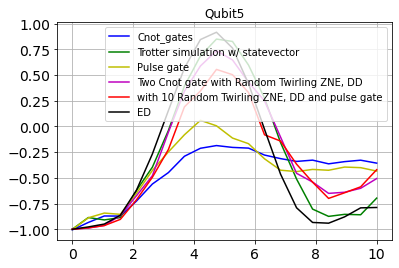

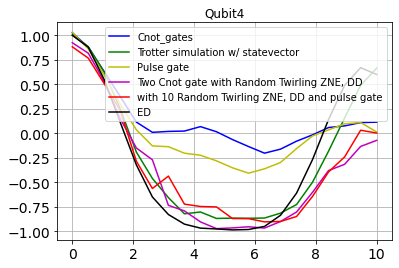

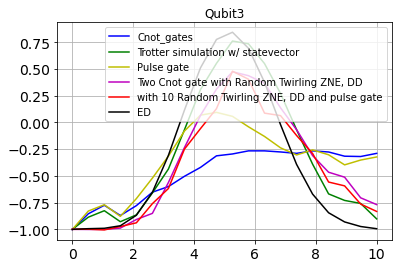

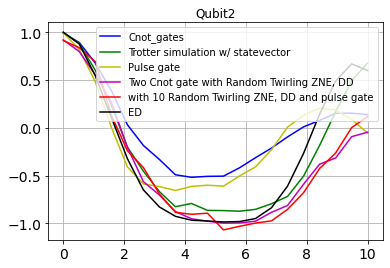

In [ ]:
for i in range(L):
    t40 = np.linspace(0,T,64)
    t=np.linspace(0,T,NN)
    plt.title("Qubit"+str(L-i))
    #plt.plot(t,real_device_dict_cnot_Twirled[i],color='r',label='Twirl, two cx and Rand ZNE')
    plt.plot(t,Sz__cnots[:,i],color='b',label='Cnot_gates')
    plt.plot(t,Sz_sim[:,i],color='g',label='Trotter simulation w/ statevector')
    #plt.plot(t40,Sz_sim40[:,i],color='g',linestyle = 'dashdot',label='Trotter simulation 40 steps w/ statevector')
    plt.plot(t,Sz__Rzz[:,i],color='y',label='Pulse gate')
    plt.plot(t,real_device_dict_cnot[i],color='m',label='Two Cnot gate with Random Twirling ZNE, DD')
    #plt.plot(t,real_device_dict_rzz[i],color='c',label='with 15 Random Twirling ZNE, DD and pulse gate')
    plt.plot(t,real_device_dict_rzz10[i],color='r',label='with 10 Random Twirling ZNE, DD and pulse gate')
    #plt.plot(t,real_device_dict_cnot_Twirled[i],color='r',label='Two Cnot gate with ZNE and twirling')
    #plt.plot(t,real_device_dict_Twirled[i],color='b',label='Pulse gate with DD, ZNE and twirling')
    #plt.plot(t,real_device_dict_Rand_Rzz_Twirled[i],color='m',label='Pulse gate, Rand ZNE and twirling')
    plt.plot(t,Zi[i,:],color='k',label='ED')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
def g(d,ei,ef):
    """
    integration is written by myself with the Simpson's rule and 3/8 Simpson's rule. Unlike Scipy's, this code can directly deal
with array with initial point and final point.
    # d: the array before integrated
    # ei: start point
    # ef: ending point
    """
    N=d.shape[0]-1
    h=(ef-ei)/N
    return ig(d,N+1,h)

def ig(d,N,h): 
    #using the Simpson's rule
    """
    The integration is written by myself with the Simpson's rule and 3/8 Simpson's rule. Unlike Scipy's, this code can directly deal
with array with initial point and final point.
    """
    if N == 1:
        return 0
    elif N==0:
        return 0
    elif N == 2:
        return (d[0]+d[1])*h/2
    elif N == 3:
        return (d[0]+4*d[1]+d[2])*h/3
    elif N == 4:
        return (d[0]+3*d[1]+3*d[2]+d[3])*3*h/8
    elif (N+1)%2 == 0:
        return ((d[N-1]+d[0]+sum(d[1::2])*4+sum(d[2:N-1:2])*2))*h/3
    elif (N+1)%2 == 1:
        return (sum(d[1:N-3:2])*4+sum(d[2:N-5:2])*2+d[0]+d[N-4])*h/3+ig(d[-4:],4,h)

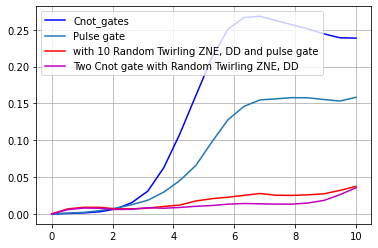

In [ ]:
Int_D_cnot_t=[]
Int_D_Rzz_t=[]
Int_D_Rzz_fold_t=[]
Int_D_cnot_fold_t=[]
for k,j in enumerate(t):
  #print(k,j)
  D_cnot=0
  D_Rzz=0
  D_Rzz_fold=0
  D_cnot_fold=0
  for i in range(L):
      #plt.title("Qubit"+str(L-i))
      D_cnot=D_cnot+np.abs(Sz_sim[:k+1,i]-Sz__cnots[:k+1,i])**2
      D_Rzz=D_Rzz+np.abs(Sz_sim[:k+1,i]-Sz__Rzz[:k+1,i])**2
      D_Rzz_fold=D_Rzz_fold+np.abs(Sz_sim[:k+1,i]-np.array(real_device_dict_rzz10[i][:k+1]))**2
      D_cnot_fold= D_cnot_fold+np.abs(Sz_sim[:k+1,i]-np.array(real_device_dict_cnot[i][:k+1]))**2

  D_cnot=D_cnot/L
  D_Rzz=D_Rzz/L
  D_Rzz_fold=D_Rzz_fold/L
  D_cnot_fold=D_cnot_fold/L

  #if k==1 or k==0:
  #  print(D_cnot)
  #  print(D_Rzz)
  #  print(D_Rzz_fold)
  #  print(D_cnot_fold)
  if j == 0:
    Int_D_cnot=0
    Int_D_Rzz=0
    Int_D_Rzz_fold=0
    Int_D_cnot_fold=0
  else:
    Int_D_cnot=g(D_cnot,0,j)/j
    Int_D_Rzz=g(D_Rzz,0,j)/j
    Int_D_Rzz_fold=g(D_Rzz_fold,0,j)/j
    Int_D_cnot_fold=g(D_cnot_fold,0,j)/j

  Int_D_cnot_t.append(Int_D_cnot)
  Int_D_Rzz_t.append(Int_D_Rzz)
  Int_D_Rzz_fold_t.append(Int_D_Rzz_fold)
  Int_D_cnot_fold_t.append(Int_D_cnot_fold)

plt.plot(t,Int_D_cnot_t,color='b',label='Cnot_gates')
plt.plot(t,Int_D_Rzz_t,label='Pulse gate')
plt.plot(t,Int_D_Rzz_fold_t,color='r',label='with 10 Random Twirling ZNE, DD and pulse gate')
plt.plot(t,Int_D_cnot_fold_t,color='m',label='Two Cnot gate with Random Twirling ZNE, DD')
plt.grid()
plt.legend()
plt.show()

# Save data point

In [ ]:
f = open(path_dir.replace('.','_Sz_cnot.'),'w')
f.write('The time step:'+str(dt)+'\n')

f.write('Sz_cnot:\n')

for i in range(L):
  f.write(str(Sz__cnots[:,i]))
  f.write('\n')

f.close()

f = open(path_dir.replace('.','_Trotter_simulation_statevector.'),'w')
f.write('The time step:'+str(dt)+'\n')

f.write('Trotter simulation w/ statevector:\n')
for i in range(L):
  f.write(str(Sz_sim[:,i]))
  f.write('\n')
f.close()

f = open(path_dir.replace('.','_Trotter_simulation_40_steps_statevector.'),'w')
f.write('The time step:'+str(dt)+'\n')

f.write('Trotter simulation 40 steps w/ statevector:\n')

for i in range(L):
  f.write(str(Sz_sim40[:,i]))
  f.write('\n')
f.close()

f = open(path_dir.replace('.','_Two_Cnot_gate_with_ZNE.'),'w')
f.write('The time step:'+str(dt)+'\n')
f.write('Two Cnot gate with ZNE:\n')

for i in range(L):
  f.write(str(real_device_dict_cnot[i]))
  f.write('\n')
f.close()

f = open(path_dir.replace('.','_ED.'),'w')
f.write('The time step:'+str(dt)+'\n')

f.write('ED:\n')
for i in range(L):
  f.write(str(Zi[i,:]))
  f.write('\n')
f.close()

# Device data

In [ ]:
for i in qubits_list:
  print('t1:',properties.t1(i)*(1e6),'us')
  print('t2:',properties.t2(i)*(1e6),'us')

In [ ]:
for i in q_conn:
  print('cx error rate:',i,' ',properties.gate_error('cx',i))
for i in qubits_list:
  print('x error rate:',i,' ',properties.gate_error('x',i))
for i in Tw_cnot_err:
  print('Two cnot error rate:',i)
for i in Rzz_err:
  print('Rzz pulse error rate:',i)